# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [1]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [30]:
ds_train = pd.read_csv("/home/tomi/Escritorio/Maestria/2 - DMEyF/datasets/resultados.csv")
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
print(clase_train.value_counts())

clase_ternaria
0    489050
1      2013
Name: count, dtype: int64


In [31]:
# rename columna A from ds_train to p_rentabilidad
ds_train = ds_train.rename(columns={"A": "p_rentabilidad"})
ds_train = ds_train.drop([ "numero_de_cliente", "foto_mes"], axis=1)


Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [32]:
ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")
ds_train = ds_train.drop(["clase_ternaria"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria"], axis=1)


In [15]:
#print type of each column  and save it to a txt
with open("/home/tomi/Escritorio/Maestria/2 - DMEyF/datasets/resultados_tipos.txt", "w") as f:
    for col in ds_train.columns:
        f.write(col + " " + str(type(ds_train[col].iloc[0])) + "\n")

Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [33]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 500,
    'verbose': 0,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


In [24]:
print(p_bajas)

[0.02933093 0.04684119 0.00401139 ... 0.00428033 0.00418571 0.00207309]


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [18]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
58,Master_fultimo_cierre,335
79,Visa_fultimo_cierre,300
94,sum_cpayroll,182
88,A,154
18,mprestamos_personales,133
...,...,...
10,ccuenta_corriente,0
99,sum_inversion,0
101,sum_inversion_pesos,0
102,sum_descuentos,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [34]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [36]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
# index of max value in p_bajas
cliente_idx = np.argmax(p_bajas)
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

0.5936111106020322


,476035,1940
p_rentabilidad,0.087827,0.046309
sum_comisiones_m,0.000000,0.010736
cliente_edad,32.000000,0.003664
ccaja_ahorro,2.000000,0.003618
thomebanking,0.000000,0.003184
...,...,...
mprestamos_personales,0.000000,-0.541722
Master_fultimo_cierre,1.000000,-0.757977
mpasivos_margen,0.160000,-0.881736
sum_cpayroll,0.000000,-0.899327


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [38]:
shap_bajas.mean().sort_values(ascending=False)


Visa_mconsumospesos      1.180194e-04
Master_msaldototal       8.213901e-07
sum_inversion_pesos      0.000000e+00
sum_descuentos           0.000000e+00
tcuentas                 0.000000e+00
                             ...     
mprestamos_personales   -2.100447e-01
mpasivos_margen         -3.818947e-01
sum_cpayroll            -4.527716e-01
Master_fultimo_cierre   -4.952217e-01
Visa_fultimo_cierre     -6.223345e-01
Length: 112, dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

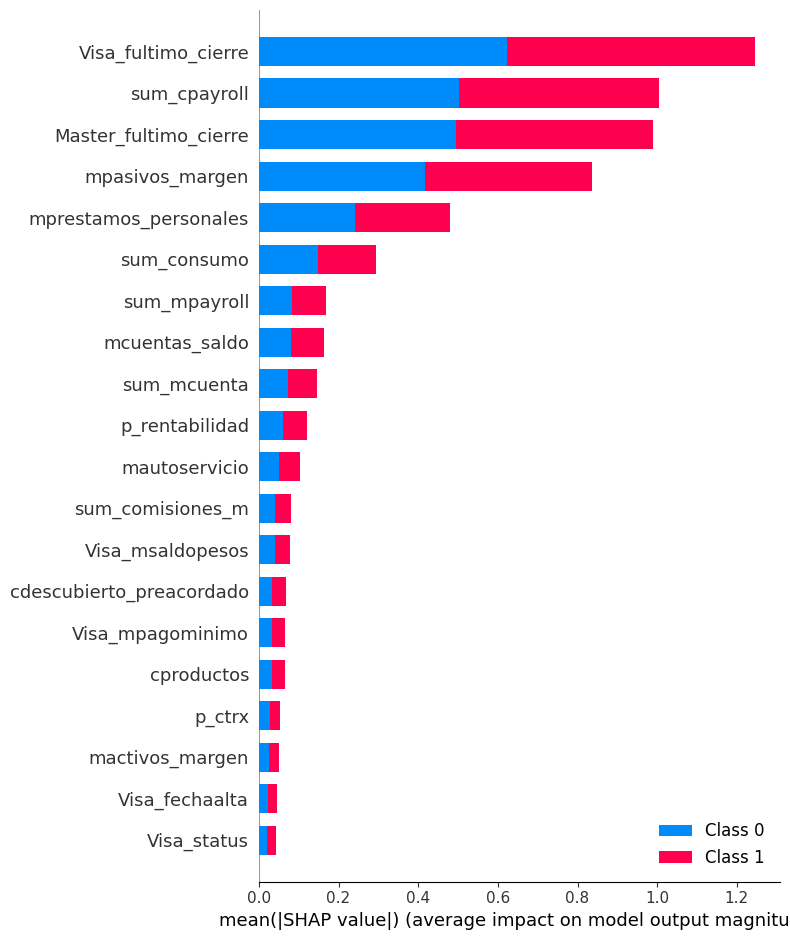

In [39]:
shap.summary_plot(shap_values, ds_bajas)


Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

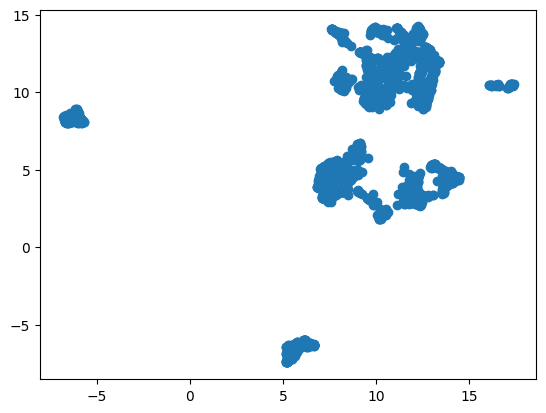

In [40]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([605., 326., 269., 236., 158., 116.,  95.,  57.,  38.,  28.,  12.,
          7.,   9.,   9.,   8.,   4.,   2.,   0.,   3.,   5.,   2.,   1.,
          2.,   2.,   6.,   2.,   3.,   4.,   1.,   3.]),
 array([0.001637  , 0.02136947, 0.04110194, 0.06083441, 0.08056688,
        0.10029935, 0.12003182, 0.13976429, 0.15949676, 0.17922923,
        0.1989617 , 0.21869417, 0.23842664, 0.25815911, 0.27789158,
        0.29762406, 0.31735653, 0.337089  , 0.35682147, 0.37655394,
        0.39628641, 0.41601888, 0.43575135, 0.45548382, 0.47521629,
        0.49494876, 0.51468123, 0.5344137 , 0.55414617, 0.57387864,
        0.59361111]),
 <BarContainer object of 30 artists>)

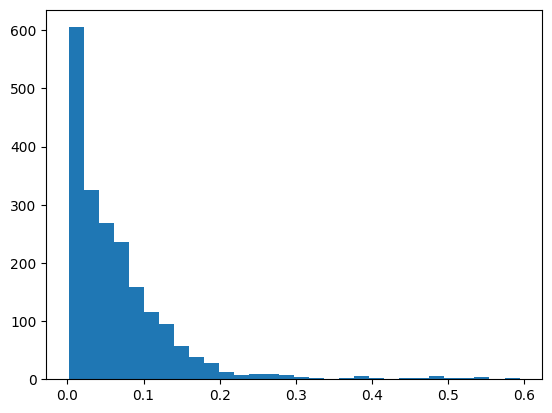

In [42]:
plt.hist(p_bajas,bins=30)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

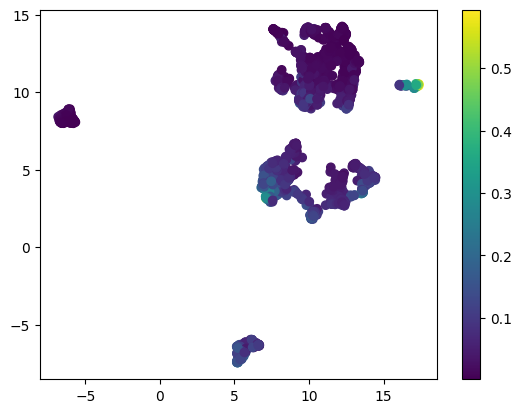

In [43]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


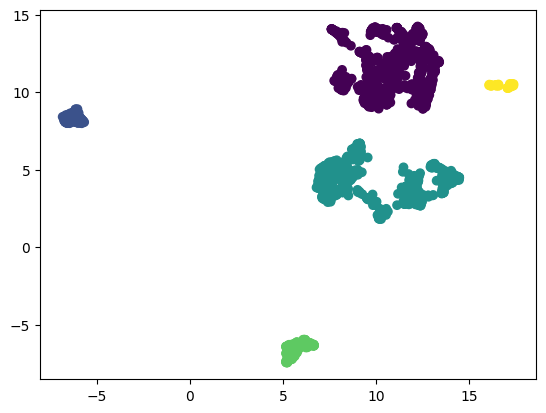

In [44]:

hdb = DBSCAN(eps=0.75) # juegue con los parámetros 
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_)
plt.show()

Comparamos 2 clusters para ver si cambian sus variables importantes

In [45]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)

sum_cpayroll             0.417376
sum_mpayroll             0.014390
mcuentas_saldo           0.001206
mcomisiones              0.000665
mtransferencias          0.000409
                           ...   
Visa_msaldopesos        -0.066174
ccaja_ahorro            -0.077053
mpasivos_margen         -0.101063
Master_fultimo_cierre   -0.221803
Visa_fultimo_cierre     -0.395047
Length: 112, dtype: float64

In [46]:
shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)

active_quarter            NaN
cliente_vip               NaN
internet                  NaN
cliente_edad              NaN
cliente_antiguedad        NaN
                           ..
cajas_balance             NaN
sum_atm                   NaN
sum_transacciones_cajas   NaN
sum_transacciones_otras   NaN
p_ctrx                    NaN
Length: 112, dtype: float64

Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

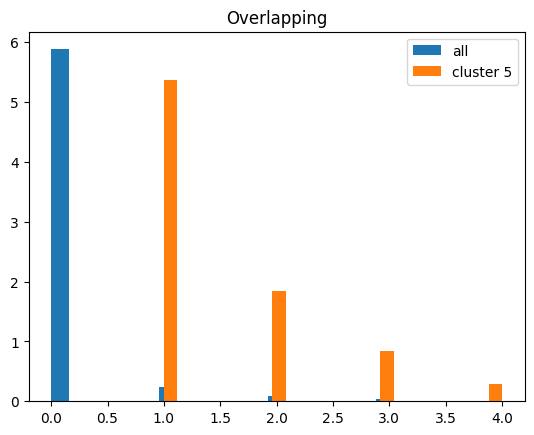

In [48]:
plt.hist(ds_bajas.loc[:]["sum_cpayroll"], label='all', density=True, bins=25)
plt.hist(ds_bajas.loc[y.labels_ == 1]["sum_cpayroll"], label='cluster 5', density=True, bins=25)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

## Random Forest distance

Veremos otro forma de llegar clusters, pero usando las distancia del Random Forest como input del embedding. Para esto, es necesario primero hacer un RF. No lo haremos con todos los datos, mantendremos todos los **BAJAS** y tan solo algunos continua.

In [72]:
np.random.seed(17)
continua_sample = clase_train[clase_train == 0].sample(2000).index
bajas_1_2 = clase_train[clase_train == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [73]:
XRF = ds_train.iloc[rf_index]
yRF = clase_train.iloc[rf_index]

In [74]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat # transforma de una matriz de proximidad a una de distancia. 


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Y pasamos nuestra matriz de distancia al UMAP

using precomputed metric; inverse_transform will be unavailable


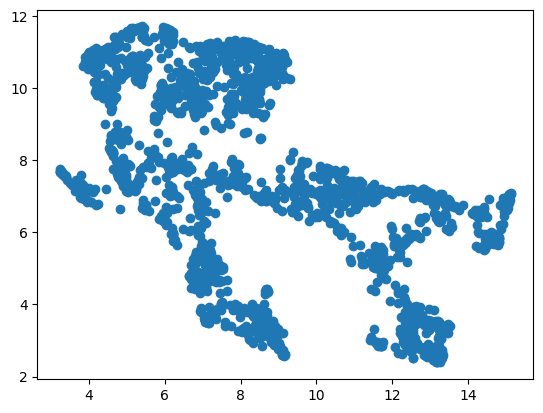

In [75]:
embedding_rf = UMAP( # Probar parámetros
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1]) # Solo los BAJAS paso... pero no sería interesante pasar todos?

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])